# Solving inverse problems on GPUs with Pylops+CuPy - Introduction

Welcome to the tutorial of this session! In this tutorial we will consider a very basic problem: **1D deconvolution**

By the end of the tutorial you will have learned:
- the basics of PyLops and how to use built-in operators to solve inverse problems.
- how you can easily switch between CPU-based to GPU-based inversion;


## Create environment with PyLops+CuPy+CuSignal

In [1]:
!chmod u+x install.sh
!./install.sh

--2021-01-30 12:01:28--  https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh [following]
--2021-01-30 12:01:28--  https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58468498 (56M) [application/x-sh]
Saving to: ‘Miniconda3-4.5.4-Linux-x86_64.sh’

Miniconda3-4.5.4-Li 100%[===================>]  55.76M   269MB/s    in 0.2s    

2021-01-30 12:01:28 (269 MB/s) - ‘Miniconda3-4.5.4-Linux-x86_

In [2]:
import sys
_ = (sys.path.append("/usr/local/lib/python3.6/site-packages"))

In [63]:
!ls /content/convolve_1D.png

/content/convolve_1D.png


## Example: 1D Deconvolution

The first problem we will solve with the aid of PyLops is a simple one-dimensional convolution/deconvolution problem. 

We start by defining:

- a 1D input signal, $f(t)$, constructed as the superposition of three gaussian functions with different time shifts;
- a PyLops operator applying convolution ([Convolve1D](https://pylops.readthedocs.io/en/latest/api/generated/pylops.signalprocessing.Convolve1D.html)) with a given impulse response $h(t)$. For simplicity, we select a [Ricker](https://en.wikipedia.org/wiki/Mexican_hat_wavelet) wavelet to be convolved with the 1D input signal. 

The resulting data, $g(t)$, is a 'blurred' shifted version of the input model mathematically computed by integration over time according to:

\begin{equation}
g(t) = \int_{-\infty}^{\infty} h(t - \tau) f(\tau) d\tau
\end{equation}

Next, we solve the inverse problem (i.e., **deconvolution**) where we seek for the model vector that would reproduce the observed data when convolved with a specific convolutional kernel.

Let's start now by importing all useful libraries

In [6]:
%matplotlib inline
import time
import os
import numpy as np
import cupy as cp
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.sparse.linalg import inv, lsqr
from scipy.sparse import rand

from pylops.utils import dottest
from pylops.utils.wavelets import ricker
from pylops.signalprocessing import Convolve1D
from pylops.optimization.sparsity import FISTA

plt.style.use('seaborn-dark')
print('cp.__version__:',  cp.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cp.__version__: 8.1.0


We can now create our model vector and convolution operator and compute the data

In [82]:
# Input parameters
t_min, t_max, nt = -4.0, 4.0, 10001 # time axis
f_central = 15 # central frequency of wavelet
t_delay = 1 # 
t_delay_wav = np.array([0.0, 0.6, 1.2])[:, np.newaxis] # times of spikes

# Time axis
t = np.linspace(t_min, t_max, nt)

# Model vector
sigma = 1 / (np.pi * f_central) ** 2
wav = np.exp(-((t - t_delay_wav) ** 2) / sigma)
model = wav[0] - 1.5*wav[1] + wav[2]

# Impulse response (Ricker wavelet)
impulse_response_full = ricker(t[nt//2:], np.sqrt(1 / (np.pi**2 * sigma)))[0]
impulse_response = impulse_response_full[np.argmax(impulse_response_full)-100:
                                         np.argmax(impulse_response_full)+101]

# Convolution operator
Rop = Convolve1D(nt, impulse_response, 
                 offset=np.argmax(impulse_response),
                 method='fft')
dottest(Rop, nt, nt, verb=True)

# Data vector
data = Rop * model

Dot test passed, v^T(Opu)=-148.452277 - u^T(Op^Tv)=-148.452277


We use here one of our sparse solvers [FISTA](https://pylops.readthedocs.io/en/latest/api/generated/pylops.optimization.sparsity.FISTA.html). 

The choice of the solver is dependant on the problem we wish to solver; here we know that to recover also the very low and high frequencies of our input model which have been removed by the filter we need to provide further prior information to the inversion in the form of a sparsity constraint.

In [ ]:
# Model reconstruction - Inverse problem
model_reconstructed = FISTA(Op=Rop,
                            data=data,
                            eps=1e-1,
                            niter=200, 
                            show=True)[0]

# Plotting input vectors
fig, ax = plt.subplots(1, 4, figsize=(16, 3), facecolor='w', edgecolor='k')
ax[0].plot(t, impulse_response_full, 'r', lw=1.5)
ax[0].set_xlabel('Time - (sec)')
ax[0].set_ylabel('Amplitude')
ax[0].set_xlim([-0.2, 0.2])
ax[0].set_title("Operator")

ax[1].plot(t, model, 'k', lw=1.5)
ax[1].set_xlabel('Time - (sec)')
ax[1].set_xlim([-0.1, 2.5])
ax[1].set_title("Model")

ax[2].plot(t, data, 'b', lw=1.5)
ax[2].set_xlabel('Time - (sec)')
ax[2].set_xlim([-0.1, 2.5])
ax[2].set_title("Data")

ax[3].plot(t, model, 'k', lw=3, label='Target Model')
ax[3].plot(t, model_reconstructed, '--g', lw=2, label='Reconstruction')
ax[3].set_ylabel('Amplitude')
ax[3].set_xlabel('Time - (sec)')
ax[3].set_xlim([-0.1, 1.5])
ax[3].set_title("Model Reconstruction")
ax[3].legend()
ax[3].set_xlim([-0.1, 2.5])
fig.tight_layout();

And we are now ready to see how the above problem can also be solved on your GPU by leveraging CuPy.

All we need to do is:

- ensure the data is transferred to the GPU via [cp.asarray](https://docs.cupy.dev/en/stable/reference/generated/cupy.asarray.html)
- create a new Convolve1D operator where the impulse response is also moved to the GPU. By doing so, PyLops knows automatically that we want to solve our problem on the GPU!

Dot test passed, v^T(Opu)=586.784582 - u^T(Op^Tv)=586.784582
FISTA optimization (soft thresholding)
-----------------------------------------------------------
The Operator Op has 10001 rows and 10001 cols
eps = 1.000000e-01	tol = 1.000000e-10	niter = 200
alpha = 8.647892e-04	thresh = 4.323946e-05
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1   0.00000e+00   4.092e+03   4.102e+03   4.914e+00
     2   0.00000e+00   2.183e+03   2.195e+03   1.454e+00
     3  -0.00000e+00   1.290e+03   1.305e+03   1.112e+00
     4   0.00000e+00   8.271e+02   8.431e+02   8.908e-01
     5  -0.00000e+00   5.650e+02   5.823e+02   7.378e-01
     6  -0.00000e+00   4.058e+02   4.242e+02   6.265e-01
     7  -0.00000e+00   3.030e+02   3.224e+02   5.424e-01
     8  -0.00000e+00   2.335e+02   2.537e+02   4.771e-01
     9  -0.00000e+00   1.848e+02   2.058e+02   4.244e-01
    10  -0.00000e+00   1.498e+02   1.714e+02   3.808e-01
    11  -0.000

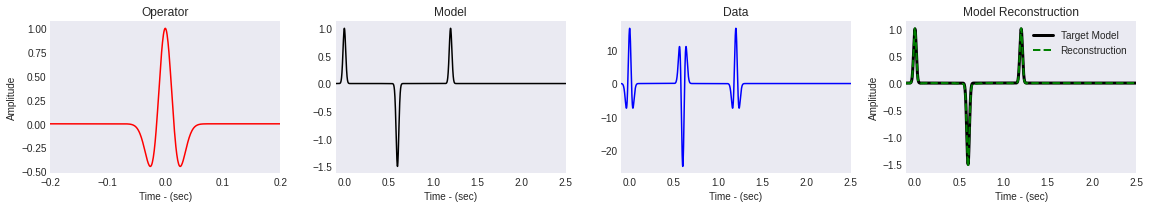

In [83]:
# Convert to cupy
Rop_cp = Convolve1D(nt, cp.asarray(impulse_response), 
                    offset=np.argmax(impulse_response),
                    method='fft')
data_cp = cp.asarray(data)
dottest(Rop, nt, nt, backend='cupy', verb=True)

# Model reconstruction - Inverse problem
model_reconstructed_cp = FISTA(Op=Rop_cp,
                               data=data_cp,
                               eps=1e-1,
                               niter=200, 
                               show=True)[0]

# Plotting input vectors
fig, ax = plt.subplots(1, 4, figsize=(16, 3), facecolor='w', edgecolor='k')
ax[0].plot(t, impulse_response_full, 'r', lw=1.5)
ax[0].set_xlabel('Time - (sec)')
ax[0].set_ylabel('Amplitude')
ax[0].set_xlim([-0.2, 0.2])
ax[0].set_title("Operator")

ax[1].plot(t, model, 'k', lw=1.5)
ax[1].set_xlabel('Time - (sec)')
ax[1].set_xlim([-0.1, 2.5])
ax[1].set_title("Model")

ax[2].plot(t, data_, 'b', lw=1.5)
ax[2].set_xlabel('Time - (sec)')
ax[2].set_xlim([-0.1, 2.5])
ax[2].set_title("Data")

ax[3].plot(t, model_, 'k', lw=3, label='Target Model')
ax[3].plot(t, cp.asnumpy(model_reconstructed_cp), '--g', lw=2, label='Reconstruction')
ax[3].set_ylabel('Amplitude')
ax[3].set_xlabel('Time - (sec)')
ax[3].set_xlim([-0.1, 1.5])
ax[3].set_title("Model Reconstruction")
ax[3].legend()
ax[3].set_xlim([-0.1, 2.5])
fig.tight_layout();

Same results, but compare the timings :D

Let's finally try to do a more extensive comparision by considering model vectors of variable lenght

Deconvolution with nt=101....
Deconvolution with nt=201....
Deconvolution with nt=301....
Deconvolution with nt=401....
Deconvolution with nt=501....
Deconvolution with nt=601....
Deconvolution with nt=701....
Deconvolution with nt=801....
Deconvolution with nt=901....
Deconvolution with nt=1001....
Deconvolution with nt=1101....
Deconvolution with nt=1201....
Deconvolution with nt=1301....
Deconvolution with nt=1401....
Deconvolution with nt=1501....
Deconvolution with nt=1601....
Deconvolution with nt=1701....
Deconvolution with nt=1801....
Deconvolution with nt=1901....
Deconvolution with nt=2001....
Deconvolution with nt=2101....
Deconvolution with nt=2201....
Deconvolution with nt=2301....
Deconvolution with nt=2401....
Deconvolution with nt=2501....
Deconvolution with nt=2601....
Deconvolution with nt=2701....
Deconvolution with nt=2801....
Deconvolution with nt=2901....
Deconvolution with nt=3001....
Deconvolution with nt=3101....
Deconvolution with nt=3201....
Deconvolution wit

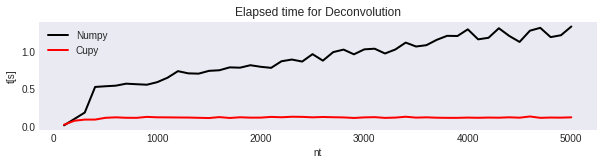

In [80]:
from deconv import deconv

# Compare timings 
nts = np.arange(100, 5100, 100) + 1

telapsed = np.vstack([np.array(deconv(nt)) for nt in nts])
plt.figure(figsize=(10, 2))
plt.plot(nts, telapsed[:, 0], 'k', lw=2, label='Numpy')
plt.plot(nts, telapsed[:, 1], 'r', lw=2, label='Cupy')
plt.xlabel('nt')
plt.ylabel('t[s]')
plt.title('Elapsed time for Deconvolution')
plt.legend()